In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'car-mileage-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1615580%2F2656528%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T080853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D762997d2e839ffce5f1d345075a34ffdd71e6899575eaa42602afa3f3b5d89de7fc81ae90179c46cccb57e739345e0111509b56d84b42469ee4cbffd20692631427439e199b8020fe96e4cce3ba39c79cd156753fe0e391e2ecbfe6ddd7e2703ae77384b99eb92c5fb024d15932093aab32b9333fc02a36e922073d7170a61cb8356cd6e3ed28b5227f0b7b66141fc6c39de0795b7b2325510f5a39ecf4964f23b0501ee47698fe4225e68b4ab428920f26cce35897d28317723b8054f7da1623929824af51519a8dbbf93344102eacde811ebc75dde29b664bc252e34e355e4febd92615e6371f28d02f4b729ca283086d9956cf153292d5a07de6fec209170'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1009 bytes downloaded
Downloaded and uncompressed: car-mileage-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-mileage-prediction/mtcars.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression


In [4]:
df = pd.read_csv('../input/car-mileage-prediction/mtcars.csv', error_bad_lines=False, engine ='python')
df

,C_name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [5]:

df.shape

(32, 12)

In [6]:
df.skew()

mpg     0.672377
cyl    -0.192261
disp    0.420233
hp      0.799407
drat    0.292780
wt      0.465916
qsec    0.406347
vs      0.264542
am      0.400809
gear    0.582309
carb    1.157091
dtype: float64

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['C_name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am',
       'gear', 'carb'],
      dtype='object')

In [9]:
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [10]:
df.isnull().sum()

C_name    0
mpg       0
cyl       0
disp      0
hp        0
drat      0
wt        0
qsec      0
vs        0
am        0
gear      0
carb      0
dtype: int64

In [11]:
df.corr()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
mpg,1.000000,-0.852162,-0.847551,-0.776168,0.681172,-0.867659,0.418684,0.664039,0.599832,0.480285,-0.550925
cyl,-0.852162,1.000000,0.902033,0.832447,-0.699938,0.782496,-0.591242,-0.810812,-0.522607,-0.492687,0.526988
disp,-0.847551,0.902033,1.000000,0.790949,-0.710214,0.887980,-0.433698,-0.710416,-0.591227,-0.555569,0.394977
hp,-0.776168,0.832447,0.790949,1.000000,-0.448759,0.658748,-0.708223,-0.723097,-0.243204,-0.125704,0.749812
drat,0.681172,-0.699938,-0.710214,-0.448759,1.000000,-0.712441,0.091205,0.440278,0.712711,0.699610,-0.090790
wt,-0.867659,0.782496,0.887980,0.658748,-0.712441,1.000000,-0.174716,-0.554916,-0.692495,-0.583287,0.427606
qsec,0.418684,-0.591242,-0.433698,-0.708223,0.091205,-0.174716,1.000000,0.744535,-0.229861,-0.212682,-0.656249
vs,0.664039,-0.810812,-0.710416,-0.723097,0.440278,-0.554916,0.744535,1.000000,0.168345,0.206023,-0.569607
am,0.599832,-0.522607,-0.591227,-0.243204,0.712711,-0.692495,-0.229861,0.168345,1.000000,0.794059,0.057534
gear,0.480285,-0.492687,-0.555569,-0.125704,0.699610,-0.583287,-0.212682,0.206023,0.794059,1.000000,0.274073


In [12]:
#Global declartions of function names
global Head
global Size
global Column_names
global Describe
global Shape
global Count
global Value_count
global ISNULL
global Tail
global Ndim
global Nunique
global Memory_usage
global Duplicated
global ISNA
global DTYPES
global CORR
global Info
global operations




# Exploratoray Data Analysis

In [13]:
 def Head(value=5):
            print('\033[1m'+'displaying the', value, 'rows'+'\033[0m')
            a=df.head(value)
            return a
            print("--------------------------------------------------------------------------")
Head()

displaying the 5 rows


,C_name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [14]:
def Tail():
    print('\033[1m'+"The last five rows of the dataframe are"+'\033[0m')
    co3=df.tail()
    return(co3)
    print("--------------------------------------------------------------------------")
Tail()

The last five rows of the dataframe are


,C_name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
27,Lotus Europa,30.4,4,95.1,113,3.77,1.513,16.9,1,1,5,2
28,Ford Pantera L,15.8,8,351.0,264,4.22,3.170,14.5,0,1,5,4
29,Ferrari Dino,19.7,6,145.0,175,3.62,2.770,15.5,0,1,5,6
30,Maserati Bora,15.0,8,301.0,335,3.54,3.570,14.6,0,1,5,8
31,Volvo 142E,21.4,4,121.0,109,4.11,2.780,18.6,1,1,4,2


In [15]:
def Column_names():
    print('\033[1m'+'Column Names in the Data set'+'\033[0m')
    c=df.columns
    print(c,'\n')
    print("--------------------------------------------------------------------------")
Column_names()

Column Names in the Data set
Index(['C_name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am',
       'gear', 'carb'],
      dtype='object') 

--------------------------------------------------------------------------


In [16]:
def Describe():
    print('\033[1m'+"The Description of our dataset is:"+'\033[0m')
    des=df.describe()
    return(des)
    print("--------------------------------------------------------------------------")
Describe()

The Description of our dataset is:


,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [17]:
def Size():
    print('\033[1m'+"The size of dataset is :"+'\033[0m')
    siz=df.size
    print(siz,'\n')
    print("--------------------------------------------------------------------------")
Size()

The size of dataset is :
384 

--------------------------------------------------------------------------


In [18]:
def Count():
    print('\033[1m'+"The count of non null values are:"+'\033[0m')
    co=df.count()
    print(co,'\n')
    print("--------------------------------------------------------------------------")
Count()

The count of non null values are:
C_name    32
mpg       32
cyl       32
disp      32
hp        32
drat      32
wt        32
qsec      32
vs        32
am        32
gear      32
carb      32
dtype: int64 

--------------------------------------------------------------------------


In [19]:
def ISNULL():
    print('\033[1m'+"Detection of missing values"+'\033[0m')
    co2=df.isnull().sum()
    print(co2,'\n')
    print("--------------------------------------------------------------------------")
ISNULL()

Detection of missing values
C_name    0
mpg       0
cyl       0
disp      0
hp        0
drat      0
wt        0
qsec      0
vs        0
am        0
gear      0
carb      0
dtype: int64 

--------------------------------------------------------------------------


In [20]:
def Ndim():
    print('\033[1m'+"The dimensions of data set are:"+'\033[0m')
    co4=df.ndim
    print(co4,'\n')
    print("--------------------------------------------------------------------------")
Ndim()

The dimensions of data set are:
2 

--------------------------------------------------------------------------


In [21]:
def Nunique():
    print('\033[1m'+"Total number of unique values are:"+'\033[0m')
    co5=df.nunique()
    print(co5,'\n')
    print("--------------------------------------------------------------------------")
Nunique()

Total number of unique values are:
C_name    32
mpg       25
cyl        3
disp      27
hp        22
drat      22
wt        29
qsec      30
vs         2
am         2
gear       3
carb       6
dtype: int64 

--------------------------------------------------------------------------


In [22]:
def Memory_usage():
    print('\033[1m'+"The total memory used is :"+'\033[0m')
    co6=df.memory_usage()
    print(co6,'\n')
    print("--------------------------------------------------------------------------")
Memory_usage()

The total memory used is :
Index     128
C_name    256
mpg       256
cyl       256
disp      256
hp        256
drat      256
wt        256
qsec      256
vs        256
am        256
gear      256
carb      256
dtype: int64 

--------------------------------------------------------------------------


In [23]:
def Duplicated():
    print('\033[1m'+"Total number of duplicate rows"+'\033[0m')
    co7=df.duplicated().count()
    return(co7)
    print("--------------------------------------------------------------------------")
Duplicated()

Total number of duplicate rows


32

In [24]:
def DTYPES():
    print('\033[1m'+"The datatypes are :"+'\033[0m')
    co9=df.dtypes
    print(co9,'\n')
    print("--------------------------------------------------------------------------")
DTYPES()

The datatypes are :
C_name     object
mpg       float64
cyl         int64
disp      float64
hp          int64
drat      float64
wt        float64
qsec      float64
vs          int64
am          int64
gear        int64
carb        int64
dtype: object 

--------------------------------------------------------------------------


In [25]:
def Info():
    print('\033[1m'+"The info of data set is :"+'\033[0m')
    co11=df.info()
    print("--------------------------------------------------------------------------")
Info()

The info of data set is :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C_name  32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB
--------------------------------------------------------------------------


In [26]:
def operations(df,x):
    if df[x].dtype=="float64":
        print('\033[1m'+'', x, 'rows'+'\033[0m')
        print('\033[1m'+"It is a quantitaive data \n"+'\033[0m')
        print("The mean is :\n",df[x].mean())
        print("The median is :\n",df[x].median())
        print("The Standard Deviation is \n",df[x].std())
        q1=df[x].quantile(0.25)
        q2=df[x].quantile(0.5)
        q3=df[x].quantile(0.75)
        IQR=q3-q1
        LLP=q1-1.5*IQR
        ULP=q3+1.5*IQR
        print("The quartiles are q1 : \n",q1)
        print("The quartiles are q2 : \n",q2)
        print("The quartiles are q3 :\n ",q3)
        print("The Uppler limit point of the data is \n",ULP)
        print("The lower limit point of the data is \n ",LLP)
        if df[x].min()>LLP and df[x].max()<ULP:
            print("The outliers are not present \n")
            print("--------------------------------------------------------------------------")

        else:

            print("The outliers are present \n")
            print("The outliers are :")
            print(df[df[x].values>ULP][x])
            print(df[df[x].values<LLP][x])

            print("--------------------------------------------------------------------------")


    elif df[x].dtype=="int64":
        print('\033[1m'+'', x, 'rows'+'\033[0m')
        print('\033[1m'+"It is a quantitaive data \n"+'\033[0m')
        print("The mean is : \n",df[x].mean())
        print("The median is : \n",df[x].median())
        print("The Standard Deviation is \n",df[x].std())
        q1=df[x].quantile(0.25)
        q2=df[x].quantile(0.5)
        q3=df[x].quantile(0.75)
        IQR=q3-q1
        LLP=q1-1.5*IQR
        ULP=q3+1.5*IQR
        print("The quartiles are q1 : \n",q1)
        print("The quartiles are q2 : \n",q2)
        print("The quartiles are q3 : \n",q3)
        print("The Uppler limit point of the data is \n",ULP)
        print("The lower limit point of the data is \n",LLP)
        if df[x].min()>LLP and df[x].max()<ULP:
            print("The outliers are not present \n")

            print("--------------------------------------------------------------------------")

        else:

            print("The outliers are present \n")
            print("The outliers are :")
            print(df[df[x].values>ULP][x])
            print(df[df[x].values<LLP][x])
            print("--------------------------------------------------------------------------")







    else:

        print('\033[1m'+"The data is Qualitative \n"+'\033[0m')


        if df[x].nunique()==1:
            print('\033[1m'+"The data is singular \n"+'\033[0m')
            print("The mode is :",df[x].mode())
            print("The count of mode is \n",df[x].value_counts())
        elif df[x].nunique()==2:
            print('\033[1m'+"The data is Binary \n"+'\033[0m')
            print("The mode is :",df[x].mode())
            print("The count of mode is \n",df[x].value_counts())
        elif df[x].nunique()>2:
            print('\033[1m'+"The data is Multi \n"+'\033[0m')
            print("The mode is :",df[x].mode())
            print("The count of mode is \n",df[x].value_counts())

        print("--------------------------------------------------------------------------")

c=df.columns
for i in c:
    operations(df,i)
    print("\n")




The data is Qualitative 

The data is Multi 

The mode is : 0             AMC Javelin
1      Cadillac Fleetwood
2              Camaro Z28
3       Chrysler Imperial
4              Datsun 710
5        Dodge Challenger
6              Duster 360
7            Ferrari Dino
8                Fiat 128
9               Fiat X1-9
10         Ford Pantera L
11            Honda Civic
12         Hornet 4 Drive
13      Hornet Sportabout
14    Lincoln Continental
15           Lotus Europa
16          Maserati Bora
17              Mazda RX4
18          Mazda RX4 Wag
19               Merc 230
20              Merc 240D
21               Merc 280
22              Merc 280C
23             Merc 450SE
24             Merc 450SL
25            Merc 450SLC
26       Pontiac Firebird
27          Porsche 914-2
28         Toyota Corolla
29          Toyota Corona
30                Valiant
31             Volvo 142E
Name: C_name, dtype: object
The count of mode is 
 Mazda RX4              1
Mazda RX4 Wag          1
Maserat

In [27]:
def Summary():
        print('\033[1m'+"The Summary of data is  \n"+'\033[0m')
        print("The shape of the datset is :",df.shape)
        print("The sixe o the data set is :",df.size)
        print("The dimensions of the dataset are:",df.ndim)
        print("The memory usage of the data set are",df.memory_usage())
        print("The data types of the dataset are:",df.dtypes)
        print("--------------------------------------------------------------------------")

Summary()

The Summary of data is  

The shape of the datset is : (32, 12)
The sixe o the data set is : 384
The dimensions of the dataset are: 2
The memory usage of the data set are Index     128
C_name    256
mpg       256
cyl       256
disp      256
hp        256
drat      256
wt        256
qsec      256
vs        256
am        256
gear      256
carb      256
dtype: int64
The data types of the dataset are: C_name     object
mpg       float64
cyl         int64
disp      float64
hp          int64
drat      float64
wt        float64
qsec      float64
vs          int64
am          int64
gear        int64
carb        int64
dtype: object
--------------------------------------------------------------------------


In [28]:
 def Column_Summary():
        print('\033[1m'+"The Column wise Summary of data is  \n"+'\033[0m')
        k=df.columns
        for i in k:
            print('\033[1m'+'', i, 'rows'+'\033[0m')
            print("The Shape of the column ",i,"is ",df[i].shape)
            print("The Size of the column ",i,"is ",df[i].size)
            print("The Dimensions of the column ",i,"is ",df[i].ndim)
            print("The Memory used by the column ",i,"is ",df[i].memory_usage())
            print("The Data types  of the column ",i,"is ",df[i].dtypes)
            print("--------------------------------------------------------------------------")
Column_Summary()

The Column wise Summary of data is  

 C_name rows
The Shape of the column  C_name is  (32,)
The Size of the column  C_name is  32
The Dimensions of the column  C_name is  1
The Memory used by the column  C_name is  384
The Data types  of the column  C_name is  object
--------------------------------------------------------------------------
 mpg rows
The Shape of the column  mpg is  (32,)
The Size of the column  mpg is  32
The Dimensions of the column  mpg is  1
The Memory used by the column  mpg is  384
The Data types  of the column  mpg is  float64
--------------------------------------------------------------------------
 cyl rows
The Shape of the column  cyl is  (32,)
The Size of the column  cyl is  32
The Dimensions of the column  cyl is  1
The Memory used by the column  cyl is  384
The Data types  of the column  cyl is  int64
--------------------------------------------------------------------------
 disp rows
The Shape of the column  disp is  (32,)
The Size of the column  disp 

In [29]:
df.columns

Index(['C_name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am',
       'gear', 'carb'],
      dtype='object')

In [30]:
#taking only numerical columns in list x for plotting distribution plot
k=df.drop(['C_name'],axis=1)

# Data VISUALIZATION

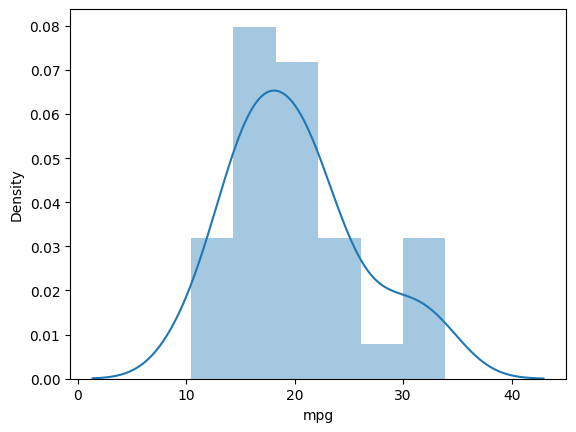

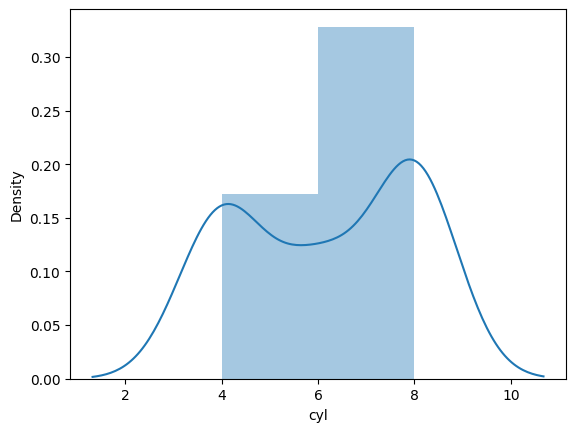

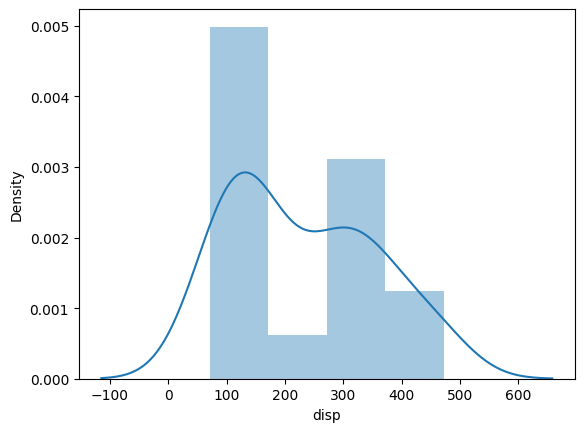

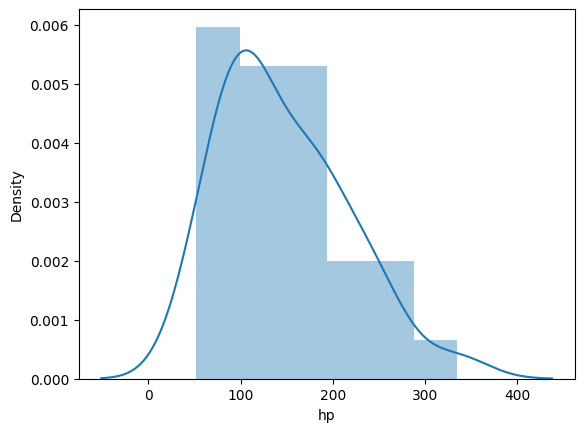

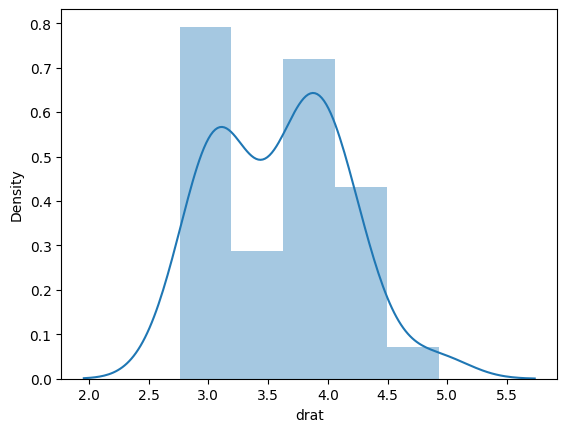

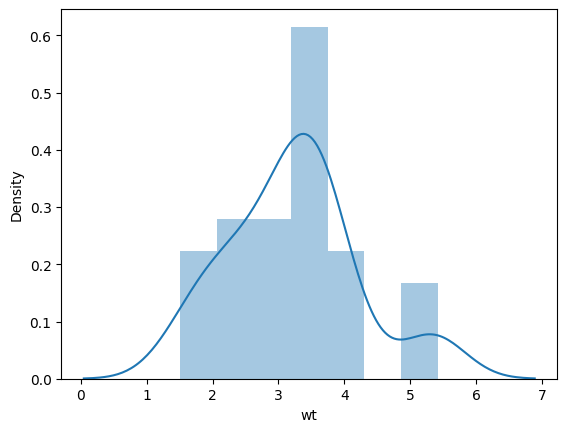

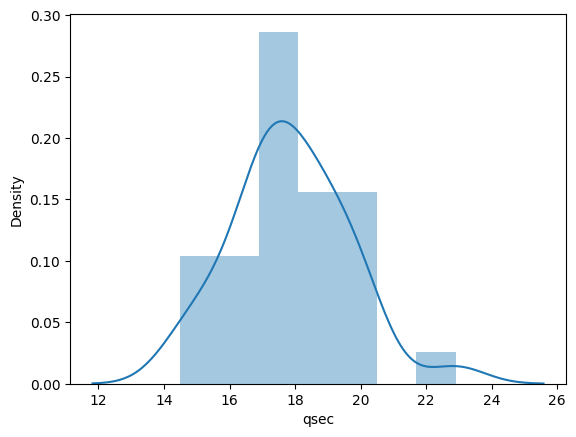

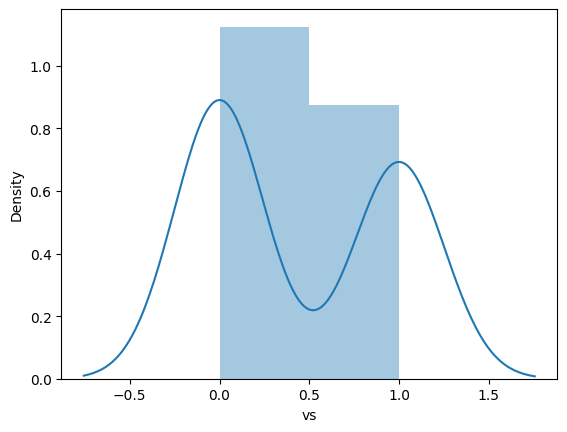

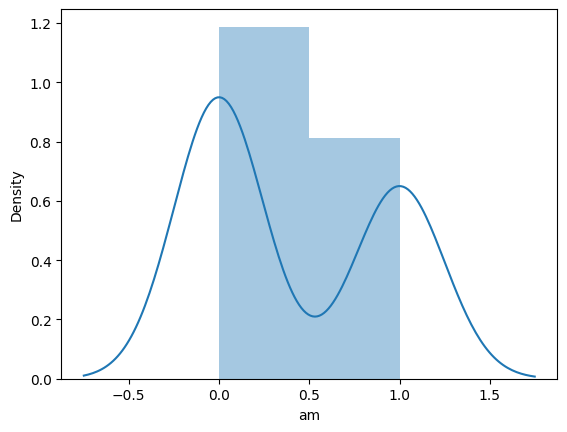

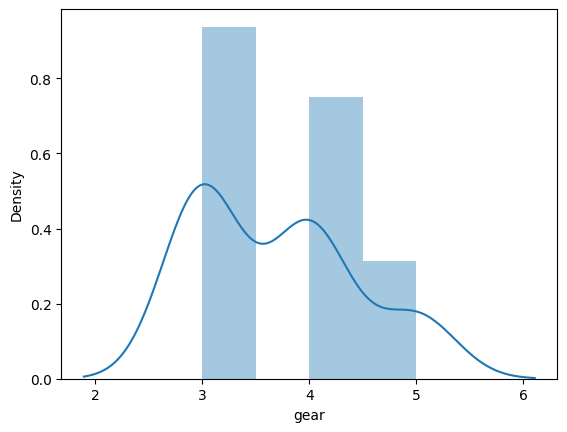

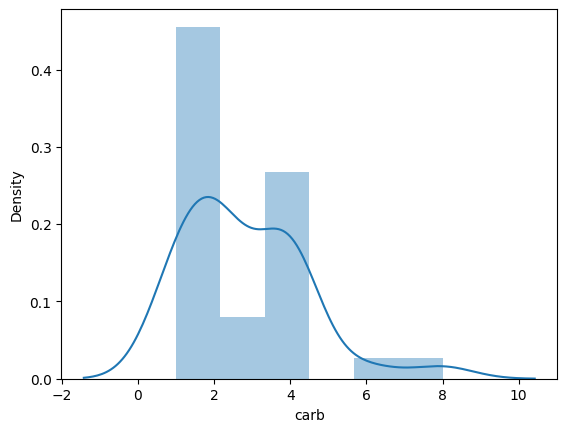

In [31]:
for i in k.columns:
    sns.distplot(df[i],kde=True)
    plt.show()

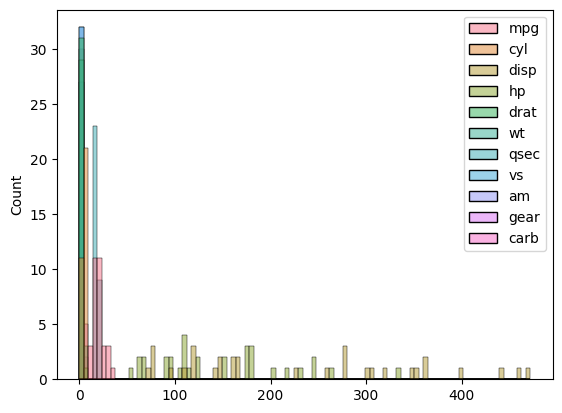

In [32]:

sns.histplot(data=k)
plt.show()

# RELATION PLOTS

Index(['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear',
       'carb'],
      dtype='object')


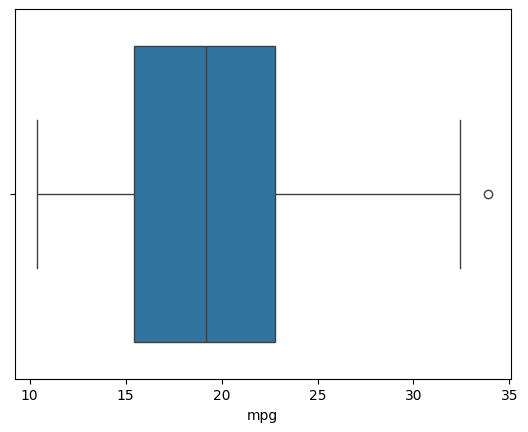

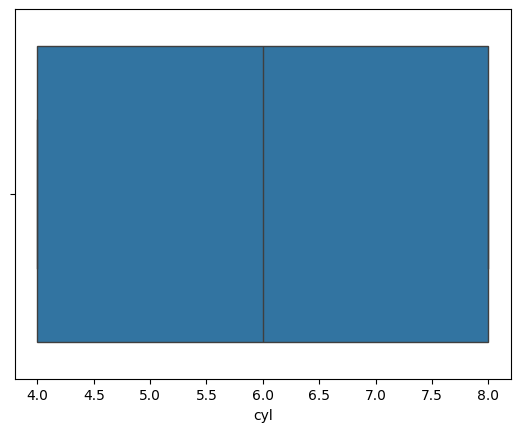

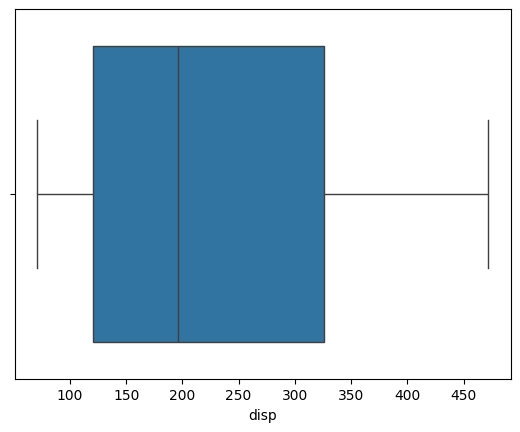

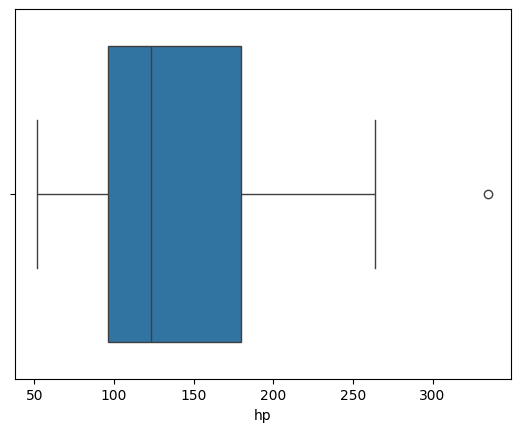

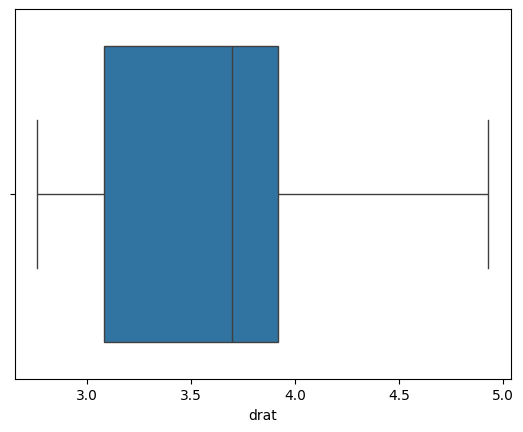

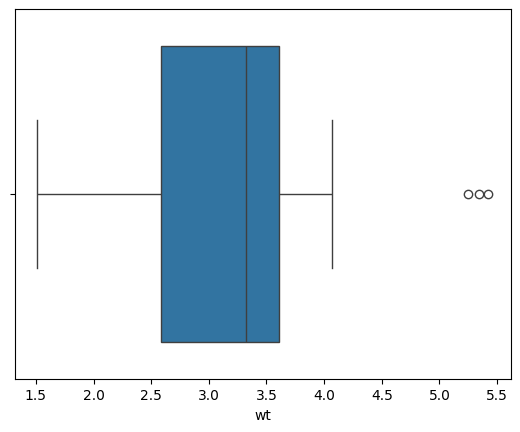

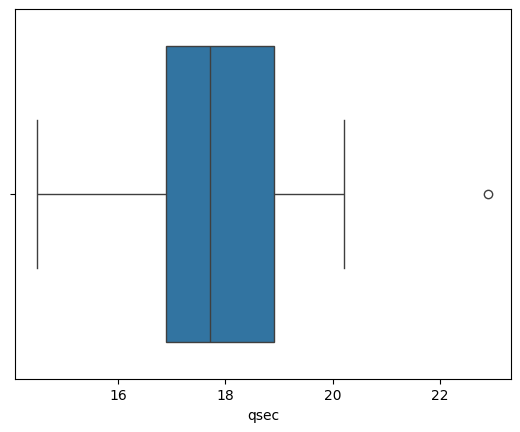

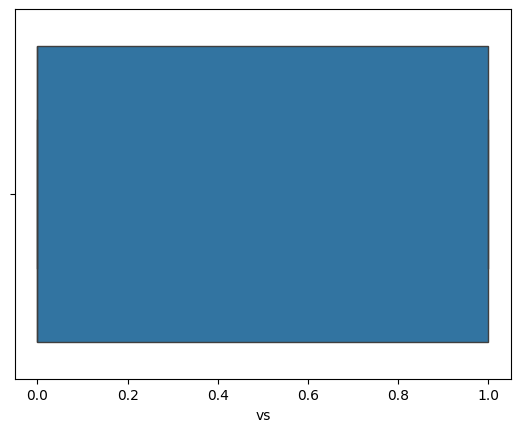

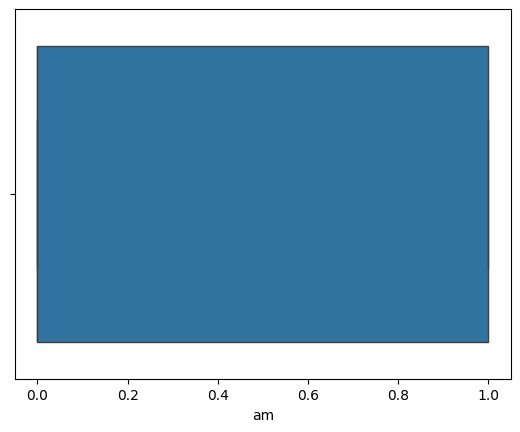

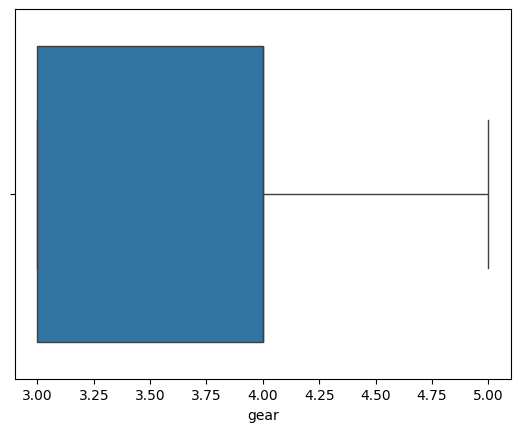

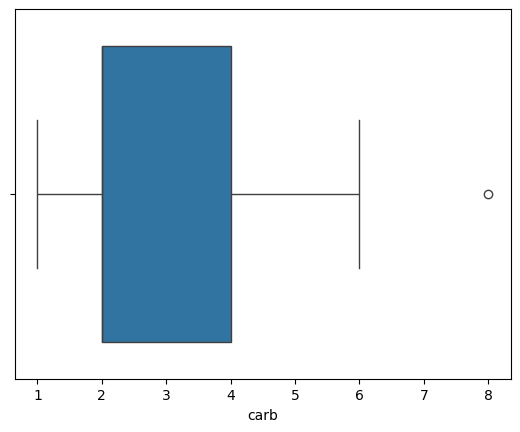

In [33]:
print(k.columns)
for i in k.columns:
    sns.boxplot(data=k,x=i)
    plt.show()

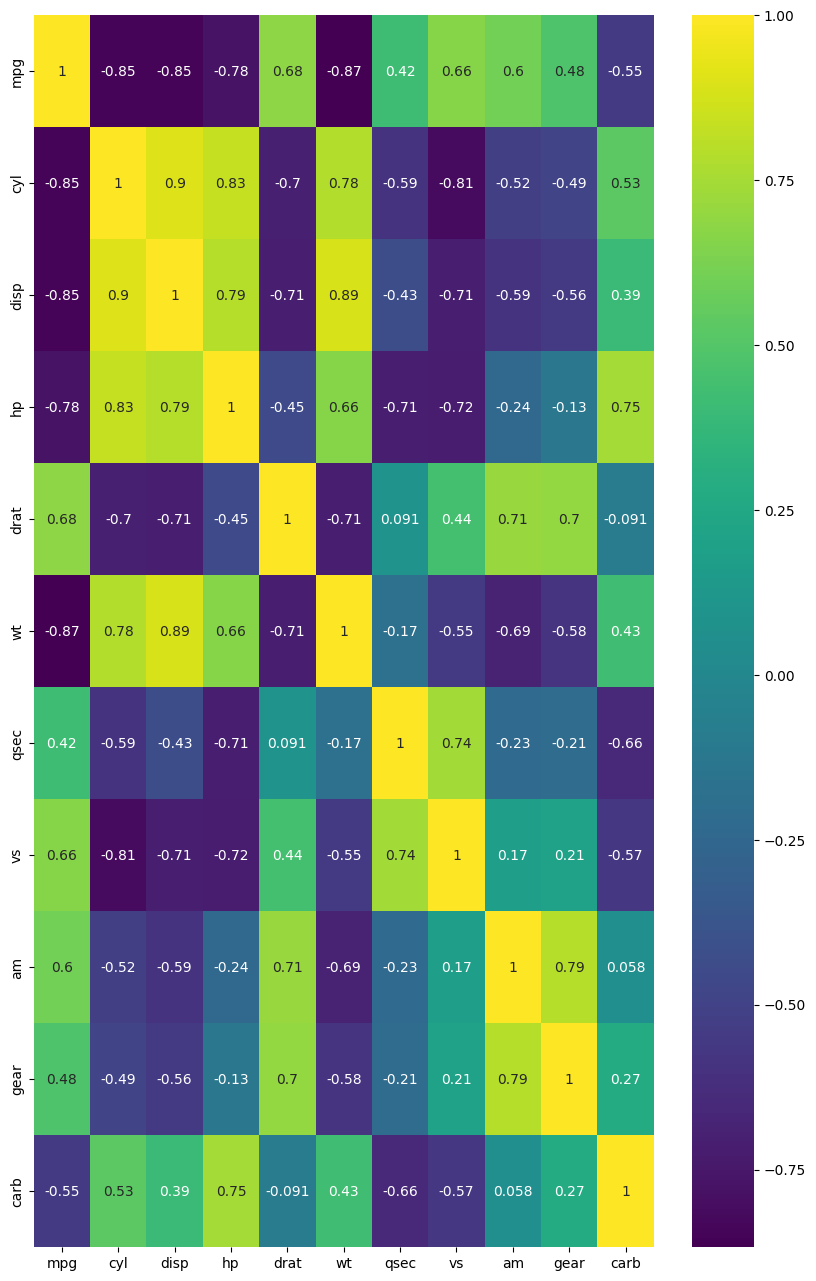

In [34]:
plt.figure(figsize=(10,16))
ax = sns.heatmap(df.corr(),annot = True, cmap = 'viridis')
plt.show()

In [35]:
for i in k.columns:
    x= df['C_name']
    y= df[i]
    data = go.Bar(x= x,y= y)
    layout = go.Layout(title = 'CARS DATA')
    fig = go.Figure(data=data,layout=layout)
    fig.show()


* Toyota Corolla has more miles per gallon than any other car
* Hornet sportabout,Duster 360,Merc 450sl,Merc 450se,Merc 450sll,Cadillac fleetwood,Lincoln continental,Chrysler,Dodge Challenger,AMCJavellin,Camaro,Pontiac Firebird,Maserati Bora have same number of cylinders
* Cadilliac has more displacement than any other cars
* Maserati bora has more horespower than any other cars
* Honda civic has more rear axle ratio than any other cars
* Lincoln Continental has more weight than any other cars
* Merc 230 has best qsec performance than any other cars
* Maserati bora has more number of carburetors than any other cars



# Data Preproccessing

In [36]:
def LABEL_ENCODING(c1):
    from sklearn import preprocessing
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()

    # Encode labels in column 'species'.
    df[c1]= label_encoder.fit_transform(df[c1])

    df[c1].unique()
    return df

In [37]:
df.columns

Index(['C_name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am',
       'gear', 'carb'],
      dtype='object')

In [38]:
LABEL_ENCODING('C_name')

,C_name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,17,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,18,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,4,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,12,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,13,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,30,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,6,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,20,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,19,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,21,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


# Data Modelling and Feature Selection

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)

StandardScaler()

In [40]:
feature=df
feature=feature.drop('mpg',axis=1)

In [41]:
label=df['mpg']

In [42]:
X_train,X_test,y_train,y_test=train_test_split(feature,label,test_size=.3)

In [43]:
print(X_train.shape,y_train.shape)

(22, 11) (22,)


In [44]:
print(X_test.shape,y_test.shape)

(10, 11) (10,)


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [46]:
forest= RandomForestRegressor(n_estimators =40, random_state = 0)

In [47]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=40, random_state=0)

In [48]:
y_pred = forest.predict(X_test)


In [49]:
forest.score(X_test,y_test)

0.8005276444484698